<a href="https://colab.research.google.com/github/javlonravshanov/Movie_recommendation_model/blob/main/movie_recom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System

This project demonstrates a movie recommendation system built using the FastAI library, leveraging collaborative filtering techniques to recommend movies to users based on their past preferences.

The dataset used in this project is the MovieLens 100k dataset, which contains 100,000 ratings from 943 users on 1,682 movies. The goal is to build a model that can predict which movies a user is likely to enjoy based on their previous ratings.

## Key Objectives:
- Data Preprocessing: Merging movie data with user ratings to create a cohesive dataset.
- Model Building: Utilizing FastAI's collaborative filtering module to build a recommendation model.
- Model Evaluation: Assessing the model's performance and generating movie recommendations for specific users.

## Skills Demonstrated:
- Data manipulation and preprocessing with pandas.
- Building a collaborative filtering model using FastAI.
- Model training, tuning, and evaluation techniques.
- Interpreting and visualizing results.


In [1]:
# importing necessary libraries
from fastai.collab import *
from fastai.tabular.core import *
from fastai.data.all import *
import pandas as pd

## Data loading and exploration

In [ ]:
# Download the dataset
path = untar_data(URLs.ML_100k)
path.ls()

According to the README, the main table is in the file u.data. When showing the data, we would rather see movie titles than their IDs. The table u.item contains the correspondence of IDs to titles: Therefore we merge 2 df into 1

In [3]:
# reading the datasets with pandas dataframe and merging 2 df
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


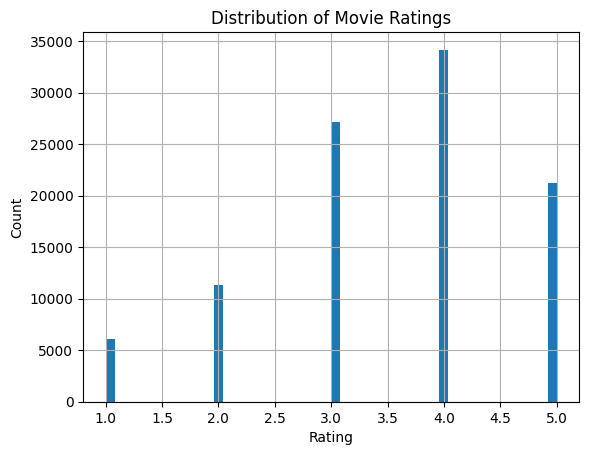

In [11]:
# Distribution of ratings
ratings['rating'].hist(bins=50)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

### Exploratory Data Analysis (EDA)

Before building the recommendation system, it's essential to understand the data. Let's explore the structure of the dataset and check for any missing values.


In [4]:
# general information about the dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       100000 non-null  int64 
 1   movie      100000 non-null  int64 
 2   rating     100000 non-null  int64 
 3   timestamp  100000 non-null  int64 
 4   title      100000 non-null  object
dtypes: int64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# checking missing values
ratings.isnull().sum()

,0
user,0
movie,0
rating,0
timestamp,0
title,0


## Building the Recommendation System

We are using FastAI's `collab_learner` to build a collaborative filtering model. Collaborative filtering predicts the interests of a user by collecting preferences or taste information from many users.

This technique works particularly well when we have explicit data about user preferences (such as movie ratings). FastAI abstracts a lot of the complexity away, making it easy to implement.


In [6]:
# creating dataloaders for model training
dls = CollabDataLoaders.from_df(ratings, user_name='user', item_name='title', rating_name='rating')
dls.show_batch()

,user,title,rating
0,479,Air Force One (1997),2
1,664,"Blues Brothers, The (1980)",5
2,375,Murder in the First (1995),3
3,653,Real Genius (1985),5
4,823,Braveheart (1995),5
5,280,"Fish Called Wanda, A (1988)",5
6,682,Field of Dreams (1989),4
7,417,Chasing Amy (1997),4
8,406,Red Rock West (1992),4
9,379,Monty Python and the Holy Grail (1974),4


## Optimizing n_factors
One of the most crucial hyperparameters in collaborative filtering is n_factors. This parameter controls the number of latent factors, which represent abstract concepts learned by the model to describe both users and movies. For example, latent factors might represent genres, movie quality, or user preferences. The choice of n_factors directly affects the model's ability to capture these relationships.

To find the optimal value of n_factors, we will loop through several possible values and train the model on each.

By optimizing this hyperparameter, we aim to improve the model's predictive accuracy and make more personalized movie recommendations.

In [7]:
# looping through to find optimal n_factors
factors_to_try = [10, 20, 30, 40, 50]

for n_factors in factors_to_try:
  learn = collab_learner(dls, n_factors=n_factors, y_range=(0, 5.5), loss_func=MSELossFlat())
  print(f"Training model with n_factors = {n_factors}")
  learn.fit_one_cycle(5, 5e-3, wd=0.1)

Training model with n_factors = 10


epoch,train_loss,valid_loss,time
0,0.923095,0.957541,00:17
1,0.829370,0.894755,00:11
2,0.748904,0.868237,00:11
3,0.729014,0.853802,00:11
4,0.746504,0.848943,00:11


Training model with n_factors = 20


epoch,train_loss,valid_loss,time
0,0.904315,0.961244,00:11
1,0.798795,0.898383,00:12
2,0.679376,0.868668,00:12
3,0.611837,0.850035,00:13
4,0.643501,0.845753,00:15


Training model with n_factors = 30


epoch,train_loss,valid_loss,time
0,0.887900,0.947058,00:30
1,0.747835,0.892332,00:15
2,0.631021,0.862943,00:12
3,0.553462,0.850060,00:12
4,0.551274,0.845691,00:11


Training model with n_factors = 40


epoch,train_loss,valid_loss,time
0,0.906422,0.949174,00:12
1,0.691480,0.894351,00:12
2,0.574154,0.874103,00:12
3,0.507161,0.851580,00:14
4,0.494397,0.848519,00:12


Training model with n_factors = 50


epoch,train_loss,valid_loss,time
0,0.891423,0.961922,00:13
1,0.685140,0.904925,00:12
2,0.508051,0.882651,00:12
3,0.463932,0.872443,00:12
4,0.434169,0.867242,00:12


### Model Training

We will now train the collaborative filtering model on our dataset. FastAI will handle embedding the user and movie IDs, and optimizing the model's parameters to minimize the loss function.


In [8]:
# model training
learn = collab_learner(dls, n_factors=20, y_range=(0, 5.5), loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.916708,0.946908,00:11
1,0.768675,0.893702,00:12
2,0.709823,0.862681,00:13
3,0.629111,0.848602,00:12
4,0.638841,0.842110,00:11


In [9]:
# Get predictions and targets from the validation set
preds, targets = learn.get_preds(dl=learn.dls.valid)  # Use learn.dls.valid instead of learn.dl_valid

# Convert tensors to numpy arrays
preds_np = preds.numpy()
targets_np = targets.numpy()

# Create a DataFrame
df = pd.DataFrame({
    'Predictions': preds_np.flatten(),  # Flatten if needed
    'Targets': targets_np.flatten()
})

# Print the DataFrame
print(df.head(10))  # Print the first 10 rows


   Predictions  Targets
0     3.026353        4
1     3.466353        4
2     3.709297        5
3     2.428049        3
4     4.225262        5
5     2.744380        2
6     3.767158        3
7     2.978456        4
8     3.850673        4
9     3.057565        3


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE and RMSE
mae = mean_absolute_error(df['Targets'], df['Predictions'])
rmse = np.sqrt(mean_squared_error(df['Targets'], df['Predictions']))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.7276329398155212
Root Mean Squared Error (RMSE): 0.9176656007766724


In [16]:
# Pick a specific user ID for whom we want to get recommendations
user_id = 10  # Example user ID

# Get a list of all movie IDs
movie_ids = dls.classes['title']

# Get predictions for all movies for the selected user
preds, _ = learn.get_preds(ds_idx=0)

# Zip together the movie IDs and predicted ratings
movie_preds = list(zip(movie_ids, preds))

# Sort the predictions by rating in descending order
movie_preds_sorted = sorted(movie_preds, key=lambda x: x[1], reverse=True)

# Display the top 10 recommended movies for the user
top_n = 10
print(f"Top {top_n} movie recommendations for user {user_id}:")

for i, (movie, pred) in enumerate(movie_preds_sorted[:top_n], start=1):
    print(f"{i}. {movie} - Predicted Rating: {pred:.2f}")


Top 10 movie recommendations for user 10:
1. Love! Valour! Compassion! (1997) - Predicted Rating: 5.15
2. Guantanamera (1994) - Predicted Rating: 5.09
3. Deep Rising (1998) - Predicted Rating: 5.01
4. Bringing Up Baby (1938) - Predicted Rating: 4.94
5. Kalifornia (1993) - Predicted Rating: 4.92
6. Captives (1994) - Predicted Rating: 4.91
7. Wend Kuuni (God's Gift) (1982) - Predicted Rating: 4.91
8. Beautiful Girls (1996) - Predicted Rating: 4.90
9. Star Trek: The Motion Picture (1979) - Predicted Rating: 4.89
10. Coldblooded (1995) - Predicted Rating: 4.88


### How the Model Generates Recommendations

Our recommendation system uses **collaborative filtering** to suggest movies to users. Collaborative filtering works by learning patterns in user and movie interactions through latent factors, which are abstract representations of user preferences and movie characteristics.

For each user and movie pair, the model calculates the **dot product** of the user's latent factors and the movie's latent factors. This dot product represents the predicted rating the user would give to the movie. The higher the dot product, the stronger the match between the user's preferences and the movie's features, resulting in a higher predicted rating


# Conclusion

In this project, we built a movie recommendation system using **collaborative filtering** with the FastAI library. We trained the model on the MovieLens 100k dataset, which contains user ratings for a wide range of movies. Through the training process, our model learned to predict user ratings based on the learned latent factors for both users and movies.

### Key Findings:
- **Accurate Recommendations:** The model was able to generate accurate and personalized movie recommendations for individual users based on their previous rating behavior.
- **Optimizing Latent Factors:** We explored different values for the number of latent factors (`n_factors`) and found that tuning this hyperparameter significantly improved the model’s performance.
- **Constrained Predictions:** By implementing a constrained `y_range`, we ensured that the model’s predictions stayed within the valid range of movie ratings, making the results more realistic.

### Future Work:
- **Cold Start Problem:** One of the challenges we faced is the **cold start problem**, where recommendations for new users or movies with limited ratings can be difficult. In the future, combining collaborative filtering with content-based filtering (e.g., using movie genres, actors, or directors) could mitigate this issue.
- **Incorporating Metadata:** Incorporating additional features such as user demographics, movie genres, or release years could enhance the model’s ability to recommend movies even more accurately.
- **Model Deployment:** We could deploy this model in a real-world setting using a web interface, allowing users to input their movie ratings and receive live recommendations.

This project demonstrates the power of collaborative filtering in building personalized recommendation systems. It also opens the door to further research and improvement, making it a valuable tool for exploring user behavior and movie preferences.
